# Project Summary: CIFAR-10 Classification, Adversarial Attack, and Mitigation

This project explored the training of a Convolutional Neural Network (CNN) for image classification on the CIFAR-10 dataset, demonstrated its vulnerability to adversarial attacks using the Fast Gradient Sign Method (FGSM), and evaluated several common image processing techniques as potential mitigation strategies.

---

## **Input & Dataset**

*   **Dataset**: CIFAR-10
    *   Comprises 60,000 32×32 RGB images distributed across 10 distinct classes (airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck).
    *   Standard split: 50,000 images for training (with 10% reserved for validation) and 10,000 images for testing.
*   **Preprocessing & Augmentation**:
    *   Images converted to PyTorch tensors.
    *   **Training Data Augmentation**: Random cropping (32x32 with padding 4) and random horizontal flips were applied to enhance model generalization.
    *   **Normalization**: Pixel values were normalized using CIFAR-10 specific mean and standard deviation values for both training and testing sets. This centers the data around zero and scales it.
        *   Train Mean: (0.4914, 0.4822, 0.4465), Std: (0.2470, 0.2435, 0.2616)
        *   Test Mean: (0.4942, 0.4851, 0.4504), Std: (0.2467, 0.2429, 0.2616)
    *   The defense (mitigation) techniques involved denormalizing images to the `[0,1]` range for processing, then re-normalizing before model inference.

---

## **Model Building & Training**

*   **Architecture**: `ImprovedCNN`
    *   A custom CNN architecture featuring three main convolutional blocks, each followed by Batch Normalization, ReLU activation, and Max Pooling.
        *   Block 1: `Conv2D(3→64) → BatchNorm → ReLU → Conv2D(64→64) → BatchNorm → ReLU → MaxPool`
        *   Block 2: `Conv2D(64→128) → BatchNorm → ReLU → Conv2D(128→128) → BatchNorm → ReLU → MaxPool`
        *   Block 3: `Conv2D(128→256) → BatchNorm → ReLU → Conv2D(256→256) → BatchNorm → ReLU → MaxPool`
    *   A classifier head with two fully connected layers, incorporating Dropout for regularization:
        *   `Flatten → Dropout(0.5) → Linear(256*4*4 → 512) → ReLU → Dropout(0.5) → Linear(512 → 10)`
*   **Training Details**:
    *   Trained for **10 epochs** using the AdamW optimizer (learning rate: 1e-3, weight decay: 1e-4).
    *   `ReduceLROnPlateau` scheduler was used to adjust the learning rate based on validation accuracy.
    *   Automatic Mixed Precision (AMP) with `GradScaler` was employed for faster training.
    *   Early stopping was implemented with a patience of 5 epochs based on validation accuracy.
*   **Training Output & Performance**:
    *   The model demonstrated good convergence, with training loss decreasing consistently.
    *   Achieved a validation accuracy of approximately **80.04%** at epoch 10.
    *   The best model (based on validation accuracy) was saved and achieved a test accuracy of approximately **81.56%**.

---

## **Adversarial Attack (FGSM)**

*   **Objective**: To generate adversarial examples that cause the trained `ImprovedCNN` model to misclassify an input image, using the Fast Gradient Sign Method (FGSM).
*   **Implementation**:
    *   Utilized the `torchattacks` library.
    *   The attack was configured to understand the CIFAR-10 normalization (mean and standard deviation) used by the model by calling `atk.set_normalization_used(mean=CIFAR_MEAN, std=CIFAR_STD)`. This ensures `eps` is applied correctly in the `[0,1]` image space internally by `torchattacks`, and the output adversarial image is correctly re-normalized.
    *   Perturbations were generated by taking the sign of the gradient of the loss function with respect to the input image and scaling it by epsilon.
*   **Attack Parameters**:
    *   Epsilon (ε): Tested with values such as `0.01`. This value represents the maximum perturbation applied to each pixel in the `[0,1]` (denormalized) image space.
*   **Attack Outcome**:
    *   Successfully demonstrated the model's vulnerability. For instance, an original "ship (#8)" image was misclassified as "automobile (#1)" with `ε=0.01`. The maximum perturbation in the normalized space was observed to be ~0.0412, consistent with `ε / min_std`.
    *   The perturbations, while effective, were designed to be small, aiming for minimal visual difference from the original image.

---

## **Mitigation Strategies**

Four common image pre-processing techniques were applied to the adversarial images to assess their ability to neutralize the adversarial perturbations and restore correct classification by the model. The adversarial image used for testing was a "ship" misclassified as "automobile" (`ε=0.01`).

### 1. **Gaussian Blur (k=3)**
    *   Method: Applied a Gaussian blur with a 3×3 kernel to the adversarial image.
    *   Effect: This smoothing operation aims to reduce high-frequency noise, which often constitutes the adversarial perturbation.
    *   Outcome: Successful Mitigation. Gaussian Blur successfully reverted the classification from "automobile (#1)" back to "ship (#8)".

### 2. **JPEG Compression (q=30)**
    *   Method: Compressed the adversarial image using JPEG with a quality factor of 30.
    *   Effect: JPEG is a lossy compression that discards some image information, particularly in high-frequency domains, potentially removing adversarial noise.
    *   Outcome: Failed Mitigation. JPEG compression did not revert the misclassification; the image remained classified as "automobile (#1)".

### 3. **Median Filter (k=3)**
    *   Method: Applied a median filter with a 3×3 kernel.
    *   Effect: Effective at removing salt-and-pepper type noise and can smooth images while preserving edges better than Gaussian blur in some cases.
    *   Outcome: Failed Mitigation. The median filter did not revert the misclassification; the image remained classified as "automobile (#1)".

### 4. **Total Variation (TV) Denoise**
    *   Method: Applied Total Variation Denoising (Chambolle's algorithm) with a weight of 0.1.
    *   Effect: This technique aims to remove noise while preserving important structural details like edges by minimizing the total variation of the image.
    *   Outcome: Successful Mitigation. TV Denoise successfully reverted the classification from "automobile (#1)" back to "ship (#8)".



import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import random_split, DataLoader

# --- 0) CUDA OPTIMIZATIONS ---
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.backends.cudnn.benchmark = True  # speed up for fixed input sizes

# --- 1) DATA AUGMENTATION & LOADERS ---
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465),
                         (0.2470, 0.2435, 0.2616)),
])
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4942, 0.4851, 0.4504),
                         (0.2467, 0.2429, 0.2616)),
])

train_full = torchvision.datasets.CIFAR10(root='./data', train=True,
                                          download=True, transform=transform_train)
val_size = int(0.1 * len(train_full))
train_size = len(train_full) - val_size
train_ds, val_ds = random_split(train_full, [train_size, val_size])

test_ds = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform_test)

trainloader = DataLoader(train_ds, batch_size=128, shuffle=True,
                         num_workers=4, pin_memory=True)
valloader   = DataLoader(val_ds,   batch_size=128, shuffle=False,
                         num_workers=4, pin_memory=True)
testloader  = DataLoader(test_ds,  batch_size=128, shuffle=False,
                         num_workers=4, pin_memory=True)

# --- 2) MODEL WITH BATCHNORM + DROPOUT ---
class ImprovedCNN(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        self.features = nn.Sequential(
            # Block 1
            nn.Conv2d(3, 64, 3, padding=1), nn.BatchNorm2d(64), nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, 3, padding=1), nn.BatchNorm2d(64), nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            # Block 2
            nn.Conv2d(64, 128, 3, padding=1), nn.BatchNorm2d(128), nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, 3, padding=1), nn.BatchNorm2d(128), nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            # Block 3
            nn.Conv2d(128, 256, 3, padding=1), nn.BatchNorm2d(256), nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, 3, padding=1), nn.BatchNorm2d(256), nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(0.5),
            nn.Linear(256 * 4 * 4, 512), nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )
    def forward(self, x):
        return self.classifier(self.features(x))

model = ImprovedCNN().to(device)

# --- 3) TRAIN / VALIDATION LOOP WITH EARLY STOPPING & AMP---
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=3, verbose=True)

scaler = torch.cuda.amp.GradScaler()  # mixed-precision scaler
best_val_acc = 0.0
patience_counter = 0
max_patience = 5

for epoch in range(1, 6):
    model.train()
    running_loss = 0.0
    for images, labels in trainloader:
        # Move to GPU non-blocking
        images = images.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True)

        optimizer.zero_grad()
        # mixed precision context
        with torch.cuda.amp.autocast():
            outputs = model(images)
            loss = criterion(outputs, labels)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item() * images.size(0)

    # --- Validation ---
    model.eval()
    correct = total = 0
    with torch.no_grad():
        for images, labels in valloader:
            images = images.to(device, non_blocking=True)
            labels = labels.to(device, non_blocking=True)
            outputs = model(images)
            _, preds = outputs.max(1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    val_acc = 100 * correct / total

    scheduler.step(val_acc)
    avg_loss = running_loss / len(train_ds)
    print(f"Epoch {epoch:02d} | Train Loss: {avg_loss:.4f} | Val Acc: {val_acc:.2f}%")

    # Early stopping
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), "best_model.pth")
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= max_patience:
            print("Early stopping triggered.")
            break

# --- 4) TEST ACCURACY WITH BEST MODEL ---
model.load_state_dict(torch.load("best_model.pth", map_location=device))
model.eval()
correct = total = 0
with torch.no_grad():
    for images, labels in testloader:
        images = images.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True)
        outputs = model(images)
        _, preds = outputs.max(1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
print(f"Test Accuracy: {100 * correct / total:.2f}%")


C:\Users\Maverick\AppData\Local\Temp\ipykernel_33216\427641186.py:56: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location

Files already downloaded and verified
Selected image with label: ship (8) from dataset index 1

Attempting FGSM attack with eps = 0.01
FGSM Attack Details for eps=0.01:
  Target (Original) Label: ship (#8)
  Original Prediction: ship (#8)
  Adversarial Prediction: automobile (#1)
  Max actual perturbation added (abs value): 0.0412
  Attack SUCCESSFUL: Adversarial image is misclassified.

Final Predictions for Plotting:
  Original: ship (#8)
  Adversarial: automobile (#1)
  JPEG (q=30): automobile (#1)
  Median (3×3): automobile (#1)
  Gaussian Blur: ship (#8)
  TV Denoise: ship (#8)


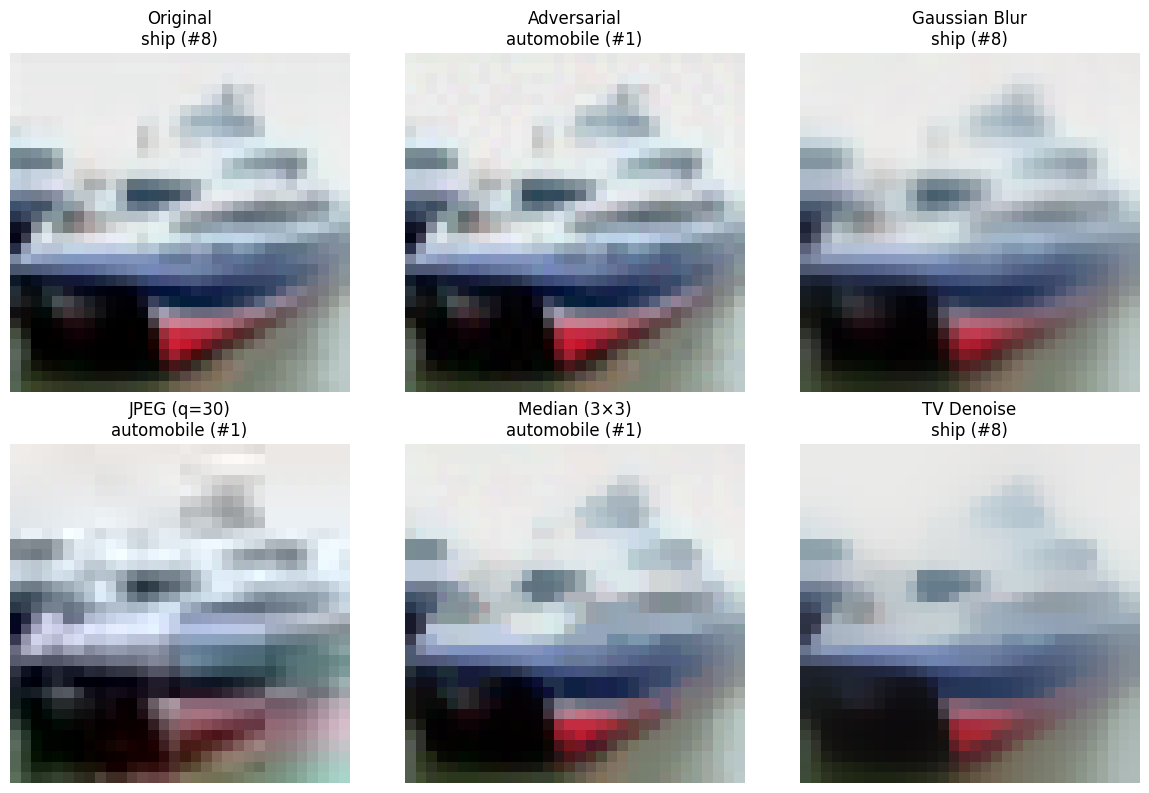

In [11]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchattacks
import matplotlib.pyplot as plt
import numpy as np
import cv2
from PIL import Image
from skimage.restoration import denoise_tv_chambolle
from torchvision.datasets import CIFAR10
import os

# --- Re-define the Model Architecture from Code_part_01 ---
class ImprovedCNN(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, 3, padding=1), nn.BatchNorm2d(64), nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, 3, padding=1), nn.BatchNorm2d(64), nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 128, 3, padding=1), nn.BatchNorm2d(128), nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, 3, padding=1), nn.BatchNorm2d(128), nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.Conv2d(128, 256, 3, padding=1), nn.BatchNorm2d(256), nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, 3, padding=1), nn.BatchNorm2d(256), nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(0.5),
            nn.Linear(256 * 4 * 4, 512), nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )
    def forward(self, x):
        return self.classifier(self.features(x))

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# CIFAR-10 class names
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

# --- CIFAR-10 Normalization constants (from Code_part_01) ---
CIFAR_MEAN = [0.4942, 0.4851, 0.4504] # Test mean
CIFAR_STD  = [0.2467, 0.2429, 0.2616] # Test std

# --- Load the TRAINED model from Code_part_01 ---
model_path = "best_model.pth"
if not os.path.exists(model_path):
    raise FileNotFoundError(f"Model file '{model_path}' not found. Please run Code_part_01 first.")

model = ImprovedCNN().to(device)
try:
    model.load_state_dict(torch.load(model_path, map_location=device))
except RuntimeError as e:
    print(f"Trying to load with weights_only=True due to error: {e}")
    model.load_state_dict(torch.load(model_path, map_location=device, weights_only=True))
model.eval()

# --- Transforms ---
normalize_transform = transforms.Normalize(CIFAR_MEAN, CIFAR_STD)
denormalize_transform = transforms.Compose([
    transforms.Normalize(mean=[0., 0., 0.], std=[1/s for s in CIFAR_STD]),
    transforms.Normalize(mean=[-m for m in CIFAR_MEAN], std=[1., 1., 1.]),
])
eval_transform = transforms.Compose([
    transforms.ToTensor(),
    normalize_transform
])

# --- Image Selection ---
TARGET_LABEL = 8 # ship. Try 3 for 'cat', 0 for 'airplane', etc.
cifar_dataset_test = CIFAR10(root='./data', train=False, download=True, transform=None) # Load as PIL first

img_pil = None
original_index_in_dataset = -1
for i, (pil_img_data, lbl) in enumerate(cifar_dataset_test): # pil_img_data is already PIL Image
    if lbl == TARGET_LABEL:
        img_pil = pil_img_data
        label = lbl
        original_index_in_dataset = i
        print(f"Selected image with label: {class_names[label]} ({label}) from dataset index {original_index_in_dataset}")
        break
if img_pil is None:
    raise ValueError(f"Could not find an image with label {TARGET_LABEL}")

img_normalized = eval_transform(img_pil).unsqueeze(0).to(device)


# --- Prediction function (expects normalized tensor) ---
def predict_label(img_tensor_normalized):
    model.eval()
    with torch.no_grad():
        outputs = model(img_tensor_normalized.to(device))
        _, pred = outputs.max(1)
    return pred.item()

# --- Adversarial Attack (FGSM) ---
model.eval()
FGSM_EPS = 0.01  # <<<<<<< ADJUST THIS VALUE if attack fails or is too strong
                 # Common values to try: 0.01, 0.03, 0.05, 0.07, 0.1
atk = torchattacks.FGSM(model, eps=FGSM_EPS)
atk.set_normalization_used(mean=CIFAR_MEAN, std=CIFAR_STD)

print(f"\nAttempting FGSM attack with eps = {FGSM_EPS}")
# Use .clone() on img_normalized to ensure the original tensor isn't modified by the attack object if it caches inputs
img_adv_normalized = atk(img_normalized.clone(), torch.tensor([label]).to(device))

# --- Verification of perturbation and attack success ---
original_pred_idx = predict_label(img_normalized)
adversarial_pred_idx = predict_label(img_adv_normalized)

perturbation = img_adv_normalized - img_normalized
max_actual_perturbation = torch.abs(perturbation).max().item()

print(f"FGSM Attack Details for eps={FGSM_EPS}:")
print(f"  Target (Original) Label: {class_names[label]} (#{label})")
print(f"  Original Prediction: {class_names[original_pred_idx]} (#{original_pred_idx})")
print(f"  Adversarial Prediction: {class_names[adversarial_pred_idx]} (#{adversarial_pred_idx})")
print(f"  Max actual perturbation added (abs value): {max_actual_perturbation:.4f}")

if original_pred_idx != adversarial_pred_idx:
    print("  Attack SUCCESSFUL: Adversarial image is misclassified.")
else:
    print("  Attack FAILED: Adversarial image is still classified as original. Consider increasing eps or trying a different image/attack.")


# --- Helper function to convert tensor to displayable numpy image ---
def tensor_to_display_np(img_tensor_normalized):
    img_denormalized = denormalize_transform(img_tensor_normalized.squeeze(0).cpu())
    img_np = np.clip(img_denormalized.permute(1, 2, 0).numpy(), 0, 1)
    return img_np

# --- Display function ---
def imshow_processed(img_tensor_normalized, title):
    img_np_display = tensor_to_display_np(img_tensor_normalized)
    plt.imshow(img_np_display)
    plt.axis('off')
    plt.title(title)

# --- Defense Mechanisms (Inputs are NORMALIZED tensors, outputs are NORMALIZED tensors) ---
def jpeg_compress(img_tensor_normalized, quality=30):
    img_denorm_squeezed = denormalize_transform(img_tensor_normalized.squeeze(0).cpu())
    img_np_0_1 = img_denorm_squeezed.permute(1, 2, 0).numpy()
    img_np_0_255 = (np.clip(img_np_0_1, 0, 1) * 255).astype(np.uint8)
    encode_param = [int(cv2.IMWRITE_JPEG_QUALITY), quality]
    _, encimg = cv2.imencode('.jpg', cv2.cvtColor(img_np_0_255, cv2.COLOR_RGB2BGR), encode_param)
    decimg_bgr = cv2.imdecode(encimg, 1)
    decimg_rgb_0_255 = cv2.cvtColor(decimg_bgr, cv2.COLOR_BGR2RGB)
    decimg_rgb_0_1 = decimg_rgb_0_255 / 255.0
    processed_tensor_0_1 = torch.tensor(decimg_rgb_0_1.transpose(2, 0, 1)).float()
    return normalize_transform(processed_tensor_0_1).unsqueeze(0).to(device)

def median_filter(img_tensor_normalized, ksize=3):
    img_denorm_squeezed = denormalize_transform(img_tensor_normalized.squeeze(0).cpu())
    img_np_0_1 = img_denorm_squeezed.permute(1, 2, 0).numpy()
    img_np_0_255 = (np.clip(img_np_0_1, 0, 1) * 255).astype(np.uint8)
    img_filtered_0_255 = cv2.medianBlur(img_np_0_255, ksize)
    img_filtered_0_1 = img_filtered_0_255 / 255.0
    processed_tensor_0_1 = torch.tensor(img_filtered_0_1.transpose(2, 0, 1)).float()
    return normalize_transform(processed_tensor_0_1).unsqueeze(0).to(device)

def gaussian_blur(img_tensor_normalized, ksize=3): # ksize must be odd
    img_denorm_squeezed = denormalize_transform(img_tensor_normalized.squeeze(0).cpu())
    img_np_0_1 = img_denorm_squeezed.permute(1, 2, 0).numpy()
    img_blurred_0_1 = cv2.GaussianBlur(np.clip(img_np_0_1,0,1), (ksize, ksize), 0) # Clip before blur too
    processed_tensor_0_1 = torch.tensor(img_blurred_0_1.transpose(2, 0, 1)).float()
    return normalize_transform(processed_tensor_0_1).unsqueeze(0).to(device)

def tv_denoise(img_tensor_normalized, weight=0.1):
    img_denorm_squeezed = denormalize_transform(img_tensor_normalized.squeeze(0).cpu())
    img_np_0_1 = np.clip(img_denorm_squeezed.permute(1, 2, 0).numpy(), 0, 1)
    img_denoised_0_1 = denoise_tv_chambolle(img_np_0_1, weight=weight, channel_axis=-1)
    processed_tensor_0_1 = torch.tensor(img_denoised_0_1.transpose(2, 0, 1)).float()
    return normalize_transform(processed_tensor_0_1).unsqueeze(0).to(device)

# --- Create processed images (all inputs to defenses are normalized adversarial images) ---
# Use .clone() to ensure each defense gets a fresh copy of the adversarial image
img_jpeg_normalized = jpeg_compress(img_adv_normalized.clone())
img_median_normalized = median_filter(img_adv_normalized.clone())
img_blur_normalized = gaussian_blur(img_adv_normalized.clone(), ksize=3) # Ensure ksize is odd
img_tv_normalized = tv_denoise(img_adv_normalized.clone())

# --- Get predictions for all images ---
predictions_final = {
    "Original": original_pred_idx, # Use already computed prediction
    "Adversarial": adversarial_pred_idx, # Use already computed prediction
    "JPEG (q=30)": predict_label(img_jpeg_normalized),
    "Median (3×3)": predict_label(img_median_normalized),
    "Gaussian Blur": predict_label(img_blur_normalized),
    "TV Denoise": predict_label(img_tv_normalized)
}

# --- Define the images dictionary for plotting (all tensors should be normalized) ---
images_to_plot = {
    "Original": img_normalized,
    "Adversarial": img_adv_normalized,
    "Gaussian Blur": img_blur_normalized,
    "JPEG (q=30)": img_jpeg_normalized,
    "Median (3×3)": img_median_normalized,
    "TV Denoise": img_tv_normalized
}

# --- Plotting ---
print("\nFinal Predictions for Plotting:")
for name, pred_idx_val in predictions_final.items():
    print(f"  {name}: {class_names[pred_idx_val]} (#{pred_idx_val})")

plt.figure(figsize=(12, 8))
plot_order = ["Original", "Adversarial", "Gaussian Blur", "JPEG (q=30)", "Median (3×3)", "TV Denoise"]
for idx, name in enumerate(plot_order):
    plt.subplot(2, 3, idx + 1)
    image_tensor_normalized = images_to_plot[name]
    pred_idx_val = predictions_final[name]
    pred_name = class_names[pred_idx_val]
    imshow_processed(image_tensor_normalized, f"{name}\n{pred_name} (#{pred_idx_val})")
plt.tight_layout()
plt.show()